Keep Hbond.dat-files in a folder named UDNAHbonds/CDNAHbonds and name the file according to the residuenumber, like so: hbondswrap5.dat (for the 5th residue).
This Code performs an autocorrelation of the data and saves the exponential fits in a folder named Lifetime_Plots.
It also creates two -.npy files, which contain a 2d-array which can be plotted with the script Lifetime_Results.

In [1]:
import numpy as np
from __future__ import division
np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties
Catoms = ['O2','N1','N3','N4','H41','H42']
Uatoms = ['N1','O2','N3','O4']
def fitfunc(x,a,b,c,d):
    return a*np.exp(-x/b) + (1-a)*np.exp(-x/d)

In [2]:
def autocorr(array):
    col = []
    for i in range(1,len(array)-1):
        col.append(np.sum(array[:-i]*array[i:]))
    norm = max(col)
    col = col/norm
    return col

In [9]:
def autocorrplot():
    choice = None
    q = input('Enter u for UDNA and c for CDNA')
    if q == 'u':
        choice = 'U'
        atomlist = Uatoms
    elif q == 'c':
        choice = 'C'
        atomlist=Catoms
        
    numatoms = stop = len(atomlist)    
    #creating empty arrays for later calculation
    lifetime = np.zeros((numatoms*(stop-0),3))
    deathtime = np.zeros((numatoms*(stop-0),3))
    lifelist = np.zeros((numatoms,2))
    deathlist = np.zeros((numatoms,2))
    
    plot=[]
        
        
    for j in range(len(atomlist)):
        data = choice+'_atomic/'+str(atomlist[j])+'.dat'
        dat = np.loadtxt(data)
        maxval=int(max(dat[:,1]))
        matrix = np.zeros((maxval,len(dat[:,1])))
        for k in range(0,maxval):
            for i in range(len(dat[:,1])):
                a = dat[i,1]
                if a == k+1: #k 0s at 0, we want a to 0 at 1
                    matrix[k,i]=1
                else:
                    pass
        plot.append(matrix)
    
    #beginning autocorrelation
    print('...autocorrelating...')
    for i in range(numatoms):
        for j in range(0,stop-1):
            jo = autocorr(plot[i][j+0][0:500:1])
            plt.plot(autocorr(plot[i][j+0][0:500:1]))
            plt.show()
            x = np.linspace(0,1000,len(jo))
            #first and last point have lower errors, so scipy.curve_fit doesn't get lost
            sigma = np.ones(len(x))
            sigma[[1,-1]]=0.3
            
            #never trust scipy.curve_fit
            bounds = ([-np.inf,-np.inf,-np.inf,0],[np.inf,np.inf,1,np.inf])
            try:
                params = curve_fit(lambda t,a,b,c,d: fitfunc(t,a,b,c,d), x, jo,[0.5,-2000000,0.5,4],sigma=sigma,bounds=bounds)
                if params[0][1]==23500000.0:
                    try:
                        params = curve_fit(lambda t,a,b,c,d: fitfunc(t,a,b,c,d), x, jo,[0.6,-200000000/p,0.4,20/p],sigma=sigma,bounds=bounds)
                    except:
                        pass
            except:
                for p in range(30):
                    try:
                        params = curve_fit(lambda t,a,b,c,d: fitfunc(t,a,b,c,d), x, jo,[0.73,-2000000/p,0.27,3/p],sigma=sigma,bounds=bounds)
                    except:
                        pass
                    
                    
            #array organisation for later averaging of Hbond lifetime per residue
            
            for k in range(len(params[0])):
                params[0][k]=round(params[0][k],3)
            bondingtime= min(abs(params[0][1]),abs(params[0][3]))* params[0][2]
            unbondingtime=max(abs(params[0][1]),abs(params[0][3]))
            lifetime[j+4*i]=[i,j+1,bondingtime]
            deathtime[j+4*i]=[i,j+1,unbondingtime]
            
                
            #saving Fitplots
            
            if i == 0:
                print('...plotting...')
            #plot autocorrelation data with fit 
            fig = plt.figure()
            plt.plot(x,jo,'. ',label=str(params[0][3]))
            plt.plot(x,fitfunc(x,params[0][0],params[0][1],params[0][2],params[0][3]))
            plt.title('Atom '+str(atomlist[i])+' with '+str(1+j)+' Hbonds')
            plt.ylabel('Autocorrelation')
            plt.xlabel('Lag in Picoseconds')
            plt.legend()
            fig.set_size_inches(10,5)
            plt.savefig(choice+'_Atomic_Fit_Plots/'+str(atomlist[i])+'no'+str(0+j)+'.png')
           
        
    #Averaging of Hbond lifetime per residue
        
        
    for i in range(0,numatoms):
        lifesummand = lifetime[lifetime[:,0]==i]
        deathsummand = deathtime[deathtime[:,0]==i]
        lifeweight = 0
        deathweight = 0
        for j in range(len(lifesummand)):
            lifeweight+=lifesummand[j,1]*lifesummand[j,2]
            deathweight+=deathsummand[j,1]*deathsummand[j,2]
        life = lifeweight/np.sum(lifesummand[:,1])
        death = deathweight/np.sum(deathsummand[:,1])
        
        
        #OUTPUTLIST
        
        lifelist[i]=[int(i),life]
        deathlist[i] = [int(i),death]
        
        tosave=lifelist[:,1]
        if choice == 'U':
            filename = 'Lifetime_Plots/U_Atom_Hbond_Lifetimes'
        elif choice == 'C':
            filename = 'Lifetime_Plots/C_Atom_Hbond_Lifetimes'
        np.save(filename,tosave)
    print('Done.')

Enter u for UDNA and c for CDNAc
...autocorrelating...


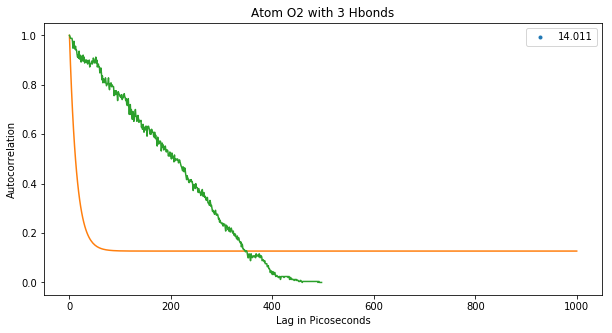

...plotting...


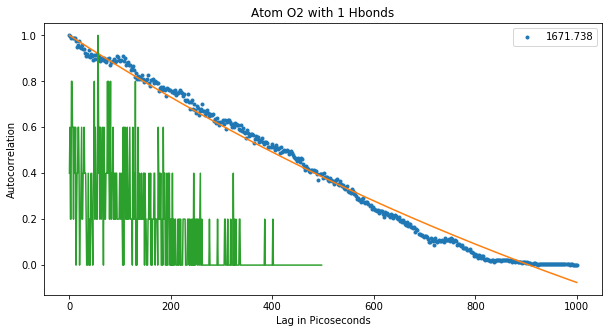

...plotting...


/usr/lib/python3/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


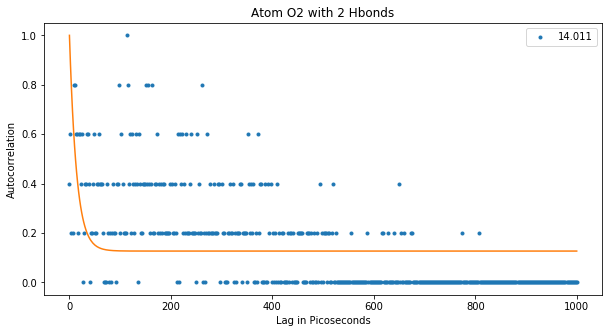

...plotting...


IndexError: index 3 is out of bounds for axis 0 with size 3

In [10]:
autocorrplot()